# Stroma Vision Machine Learning Engineer Technical Interview

**Çalışmanın amacı:** Video üzerinde düşen somun ile cıvataları yüksek doğrulukla ve hızla tespit etmek ve takip etmek.

İşaretlemelerimiz COCO veri kümesi formatında olduğu ve model olarak YOLO kullanacağımız için verileri uygun formata getirmeliyiz. 

Kullanacağımız veri kümesindeki dosya düzenimiz bu şekildedir:

```
dataset
├── labels
│   ├── train
│   ├── test
│   └── val
└── images
    ├── train
    ├── test
    └── val
```

Faydalanılan kod: https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-json-to-yolo-txt/

Videoları karelere(framelere) ayırıp 0001.jpg - 0001.txt gibi etiketlemeye denk gelecek şekilde çıkarım yapılır.

In [36]:
import cv2
from tqdm import tqdm
import os
import json
import shutil
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#Dosya yolları
vid_paths = ["./challenge/images/train/train.mp4","./challenge/images/test/test.mp4","./challenge/images/val/val.mp4"]
out_paths = ["./dataset/images/train","./dataset/images/test","./dataset/images/val"]

def extract_vid2frame(video_path, output_path):
    vidcap = cv2.VideoCapture(video_path)
    success,image = vidcap.read()
    count = 0
    out = "{output_path}/".format(output_path=output_path)
    while success:
        filename = "{count}".format(count=count)
        cv2.imwrite( out + filename.zfill(4) + ".jpg", image) #Dosya isimlerinin 4 basamaklı isimlendirilmesi(0010.jpg gibi)
        success,image = vidcap.read()
        count += 1
    print("Extraction finished. Output path: {output_path}".format(output_path=output_path))   
    
for i in range(3):
    extract_vid2frame(vid_paths[i],out_paths[i])

Extraction finished. Output path: ./dataset/images/train
Extraction finished. Output path: ./dataset/images/test
Extraction finished. Output path: ./dataset/images/val


Sonrasında json dosyasından her bir görüntü için txt dosyası olacak şekilde dönüşüm yapılır.

In [7]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    
    # YOLO bounding box format: [x_center, y_center, width, height]

    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

YOLO modeli 0'dan başlamayan etiketlemeler için hata verebiliyor. Bu yüzden aşağıda etiket ismini ve sırasını değiştirmeden numaralandırmasını değiştiriyoruz.

In [8]:
def make_folders(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)
     
    for image in tqdm(json_data["images"], desc="Annotation txt for each image"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, img_name.split(".")[0] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = anno["category_id"] - 1 #Etiketler 1-2 yerine 0-1 olarak değiştiriliyor
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

In [9]:
input_labels = ["./challenge/annotations/instances_train.json",
                "./challenge/annotations/instances_test.json",
                "./challenge/annotations/instances_val.json"]
out_labels = ["./dataset/labels/train",
              "./dataset/labels/test",
              "./dataset/labels/val"]

for j in range(3):
    convert_coco_json_to_yolo_txt(out_labels[j],input_labels[j])

C:\Users\Asus\AppData\Local\Temp\ipykernel_8740\491188809.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for image in tqdm(json_data["images"], desc="Annotation txt for each image"):


Annotation txt for each image:   0%|          | 0/7200 [00:00<?, ?it/s]

Converting COCO Json to YOLO txt finished!


Annotation txt for each image:   0%|          | 0/1800 [00:00<?, ?it/s]

Converting COCO Json to YOLO txt finished!


Annotation txt for each image:   0%|          | 0/1800 [00:00<?, ?it/s]

Converting COCO Json to YOLO txt finished!


## Preprocess işlemleri:

Bu bölümde verileri inceleyip iyileştirmeyi ve yapay zeka modeli için nesne tespitini kolaylaştırmayı hedefliyoruz.

In [7]:
#Görüntüleri incelemek için videodan çıkarılan sahnelerin dosya yolu veriliyor
path = 'C:\\Users\\Asus\\Desktop\\Stroma_Vision\\'
images = os.listdir(path + './dataset/images/train/')

In [41]:
images_list = []
#Sadece incelemek için ilk 500 görüntüyü alınıyor
for img in tqdm(images[0:500]):
    image = cv2.imread('./dataset/images/train/' + img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_list.append(image)

100%|██████████| 500/500 [00:01<00:00, 252.15it/s]


In [42]:
#Nesnelerin göründüğü bir sahne seçiliyor
preprocess_img = images_list[438].copy()

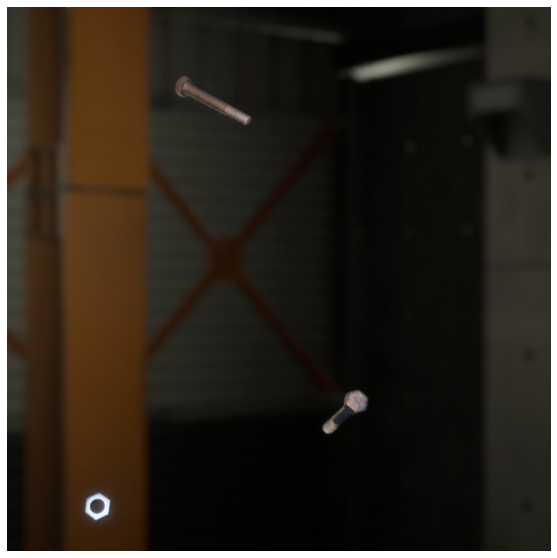

In [43]:
#Sahnenin görüntülenmesi
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(images_list[438])

(array([1.65359e+05, 4.70310e+04, 5.71430e+04, 6.31760e+04, 3.97800e+04,
        3.23760e+04, 1.75200e+03, 5.60000e+02, 5.09000e+02, 3.99000e+02,
        4.44000e+02, 4.53000e+02, 1.72000e+02, 5.10000e+01, 1.70000e+01,
        2.80000e+01, 5.00000e+01, 6.80000e+01, 1.42000e+02, 9.00000e+01]),
 array([  0. ,  12.8,  25.6,  38.4,  51.2,  64. ,  76.8,  89.6, 102.4,
        115.2, 128. , 140.8, 153.6, 166.4, 179.2, 192. , 204.8, 217.6,
        230.4, 243.2, 256. ]),
 <BarContainer object of 20 artists>)

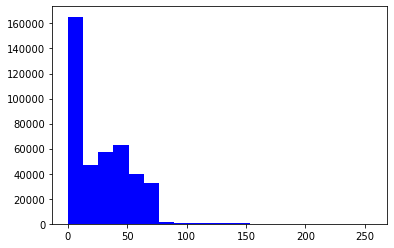

In [44]:
#RGB -> LAB renk aralığında dönüşüm yapılıyor
lab = cv2.cvtColor(preprocess_img.copy(), cv2.COLOR_RGB2LAB)
l,a,b = cv2.split(lab)
#L kanalı ile görüntünün sadece siyah-beyaz olan ve parlaklık değerlerini bulunduran katmanını alıyoruz
#Görüntünün histogram grafiğini yazdırıyoruz
plt.hist(l.flatten(),20,[0,256],color = "b")

Histogram grafiği çok düzensiz olduğu için histogram eşitleme için normal histogram eşitleme yöntemi yerine "Adaptif(Uyarlanabilir) Histogram Eşitleme - CLAHE" yöntemini kullanacağız. Bu yöntemde eşitleme görüntüde bölgesel olarak yapılıp daha iyi sonuçlar alınılabilir.

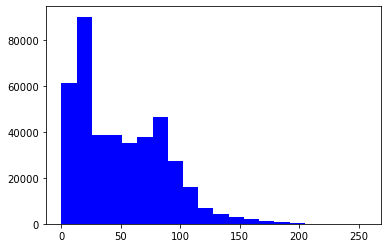

In [56]:
clahe = cv2.createCLAHE(clipLimit=4.0,tileGridSize=(16,16))
clh_img = clahe.apply(l)
plt.hist(clh_img.flatten(),20,[0,256],color = "b")
plt.show()

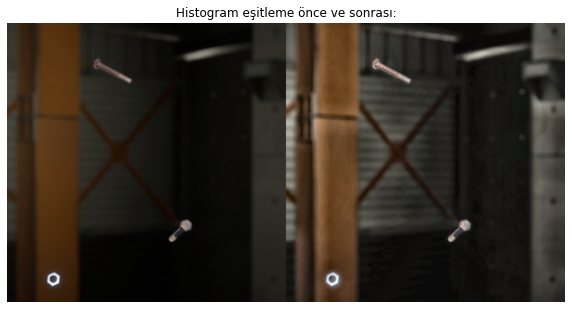

In [57]:
#L kanalı tekrar diğer kanallarla birleştiriliyor
equalized_img = cv2.merge((clh_img,a,b))
equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_LAB2RGB)
hist_imgs = np.hstack((preprocess_img,equalized_img))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title("Histogram eşitleme önce ve sonrası:")
plt.imshow(hist_imgs)

Threshold uygulayıp nesne kenarlarını çıkarmak için önce siyah-beyaza dönüşüm ve gauss bulanıklaştırması uygulanır.

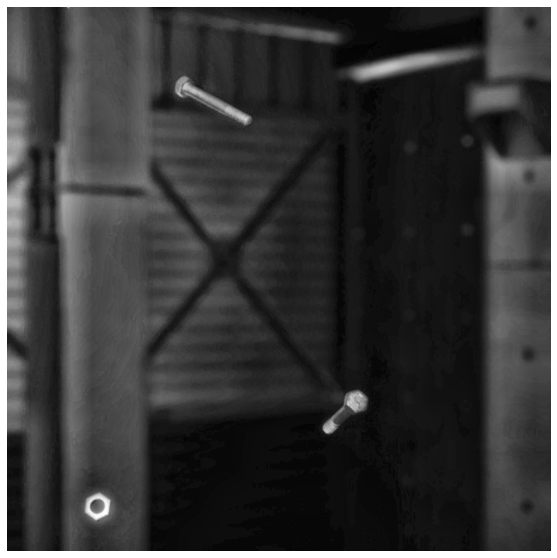

In [60]:
preprocess_img = cv2.cvtColor(equalized_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(preprocess_img, cmap='gray')

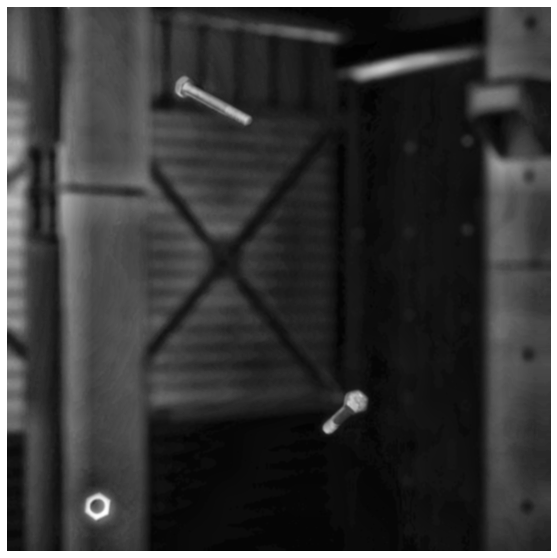

In [61]:
blur = cv2.GaussianBlur(preprocess_img,(3,3),0)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(blur, cmap='gray')

Threshold yöntemleri olarak "Binary Threshold", "Otsu Threshold" ve "Adaptive Threshold" denendi.

Diğer threshold yöntemlerine göre "Adaptive Threshold" değişen parlaklık değerlerine karşı daha iyi sonuç verdiği için bu yöntemi kullandık.

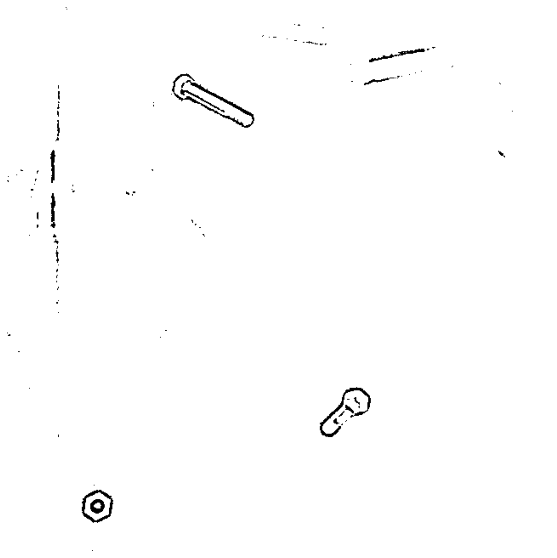

In [90]:
adaptive_th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,13,7)

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(adaptive_th, cmap='gray')

Görüntüyü basitleştirip nesneleri tespit ettik. Threshold uygulanmamış görüntüler ile modelde eğitimi yapılıp başarı sonuçlarına göre seçim yapılabilir. 

Aşağıda kod ile görüntüler tümüne aynı işlemler uygulanabilir. foldere değişkenine uygulanacak dosya yazılabilir. 

In [123]:
folder = "train"
path = 'C:\\Users\\Asus\\Desktop\\Stroma_Vision\\'
images = os.listdir(path + './dataset/images/{folder}/'.format(folder=folder))

for img in tqdm(images):
    image = cv2.imread('./dataset/images/{folder}/'.format(folder=folder) + img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=(12,12))
    clh_img = clahe.apply(l)
    equalized_img = cv2.merge((clh_img,a,b))
    equalized_img = cv2.cvtColor(equalized_img, cv2.COLOR_LAB2RGB)
    preprocess_img = cv2.cvtColor(equalized_img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(preprocess_img,(3,3),0)
    adaptive_th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,9)
    cv2.imwrite('./dataset/images/{folder}/'.format(folder=folder) + img, adaptive_th)

C:\Users\Asus\AppData\Local\Temp\ipykernel_8624\736715500.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(images):


  0%|          | 0/1800 [00:00<?, ?it/s]